Adaptado por Bruno Menezes (https://github.com/brunoleomenezes) dos estudos de Thiago Castro Ferreira (https://www.youtube.com/watch?v=GncyWR-dYW8&t=213s)e será utilizado apenas para fins acadêmicos.


# Treinamento de Word Embeddings

Na primeira parte desta aula, veremos como fazer o treinamento de Word Embeddings utilizando os métodos CBOW e skip-gram.

Para treinamento destas representações vetoriais, vamos utilizar o córpus da B2W apresentado na última aula. Vamos baixá-lo:

In [ ]:
!wget https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv

--2022-02-12 17:36:14--  https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49453175 (47M) [text/plain]
Saving to: ‘B2W-Reviews01.csv’

B2W-Reviews01.csv   100%[===================>]  47.16M   198MB/s    in 0.2s    

2022-02-12 17:36:15 (198 MB/s) - ‘B2W-Reviews01.csv’ saved [49453175/49453175]



Vamos processar as revisões do córpus, tokenizando-os e capitalizando-os em letra minúscula. 

**Observação:** Para simplificação, só utilizaremos 10 mil revisões. Fique à vontade para utilizar mais instâncias.

In [ ]:
import csv
from random import shuffle
import nltk
nltk.download('punkt')

with open('B2W-Reviews01.csv') as f:
  reader = csv.reader(f, delimiter=';', quotechar='\"')
  corpus = list(reader)

  header, corpus = corpus[0], corpus[1:]

corpus = corpus[:10000]
shuffle(corpus)

reviews = [nltk.word_tokenize(' '.join(w[0].split(',')[10:]).lower()) for w in corpus]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vamos agora separar o córpus em conjuntos de treino e teste. Para treinamento dos word embeddings, só utilizaremos o conjunto de treino:

In [ ]:
size = int(len(reviews) * 0.2)
treino = reviews[size:]
teste = reviews[:size]

len(treino), len(teste)

(8000, 2000)

## CBOW

*Continuous Bag-of-words* é uma rede neural proposta para o treinamento de word embeddings livre de contexto. A arquitetura é apresentada na imagem abaixo:

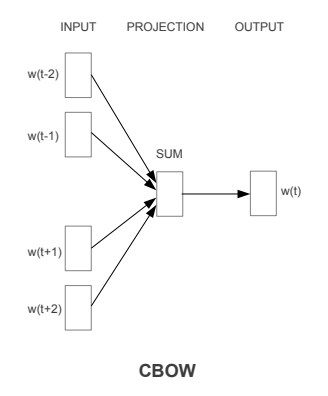

Como a imagem mostra, o modelo CBOW aprende representações vetoriais ao ser treino na de tarefa prever uma determinado token-alvo dado os tokens ao seu redor.

Vamos começar definindo o vocabulário para o qual treinaremos representações vetoriais:

In [ ]:
def get_vocab(texts):
  vocab = []
  for row in texts:
    vocab.extend(row)

  vocab = list(set(vocab))
  vocab += ['<pad>', '<oov>']
  w2id = { w:i for i, w in enumerate(vocab) }
  id2w = { i:w for i, w in enumerate(vocab) }
  return vocab, w2id, id2w

vocab, w2id, id2w = get_vocab(treino)
print('Número de palavras: ', len(vocab))

Número de palavras:  12787


Agora vamos definir os exemplos de treinamento. Como mencionado anteriormente, as redes neurais CBOW aprendem os word embeddings ao serem treinadas na tarefa de prever um token dado um contexto de tokens ao redor. Portanto devemos contruir instâncias compostas de um token e seus tokens vizinhos de acordo com uma *windows size*. Neste caso, vamos definir uma janela de tamanho 2, i.e. vamos contruir um contexto composto pelos 2 tokens anteriores e os 2 tokens subsequentes de um token alvo:

In [ ]:
def context_window(tokens, size=3):
  tokens = (['<pad>'] * size) + tokens + (['<pad>'] * size)

  contexts = []
  for i in range(size, len(tokens)-size):
    context = tokens[i-size:i] + tokens[i+1:i+size+1]
    word = tokens[i]
    contexts.append({ 'context': ' '.join(context), 'word': word })
  return contexts

data = []
wsize = 3 # windows size
for review in treino:
  data.extend(context_window(review, size=wsize))

data[10]

{'context': 'necessário e todos produtos chegam ate', 'word': 'os'}

In [ ]:
data[110]

{'context': '<pad> amei o , panelas fortes', 'word': 'conjunto'}

Vamos definir o modelo utilizando o Pytorch como aprendemos na última aula:

In [ ]:
import torch
import torch.nn as nn
from torch import optim

class CBOW(nn.Module):
  def __init__(self, inp_dim, nvocab, window_size, w2id, device):
    '''
    Inicilizando uma rede neural CBOW

    params:
    ---
      inp_dim: dimensão dos embeddings
      nvocab: tamanho do vocabulário de palavras para as quais treinaremos word embeddings
      window_size: janela de contexto
      w2id: mapping de um token para seu índice na matriz de embeddings
      device: dispositivo onde a rede neural será alocada (e.g. cpu ou cuda)
    '''
    super(CBOW, self).__init__()
    self.device = device
    self.w2id = w2id
    self.lookup = nn.Embedding(nvocab, inp_dim)
    self.Wb = nn.Linear(2 * window_size * inp_dim, nvocab)
    self.softmax = nn.LogSoftmax(1)

  def forward(self, X):
    '''
    Forward pass

    params:
    ---
      X: lista de contextos de entrada

    return:
    ---
      probabilidade entre as palavras do vocabulário
    '''
    contexts = []
    for context in X:
      idxs = []
      for token in context.split():
        try:
          idxs.append(w2id[token])
        except:
          idxs.append(w2id['<oov>'])
      contexts.append(idxs)

    contexts = torch.tensor(contexts).to(self.device)
    embeddings = self.lookup(contexts)

    batch_size, window_size, inp_dim = embeddings.size()
    concatenation = embeddings.view(batch_size, window_size * inp_dim)

    z = self.Wb(concatenation)
    return self.softmax(z)

Definindo os parâmetros da rede neural e de treinamento

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inp_dim = 300
nvocab = len(vocab)
nepochs = 1
batch_size = 256
batch_status = 256
learning_rate = 0.01
window_size = wsize

Inicializando o modelo, a função de erro e o otimizador

In [ ]:
model = CBOW(inp_dim, nvocab, window_size=window_size, w2id=w2id, device=device).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Separando o conjunto de treinamento em lotes (*batches*)

In [ ]:
from torch.utils.data import DataLoader

traindata = DataLoader(data, batch_size=batch_size, shuffle=True)

Treinando

In [ ]:
for epoch in range(nepochs):
  losses = []
  for batch_idx, row in enumerate(traindata):
    X = row['context']
    y = []
    for word in row['word']:
      try:
        y.append(w2id[word])
      except:
        y.append(w2id['oov'])
    y = torch.tensor(y).to(device)

    # Forward
    outputs = model(X)
    
    # Calculate loss
    loss = criterion(outputs, y)
    losses.append(float(loss))
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(
                            epoch+1, batch_idx + 1, len(traindata),
                            100. * batch_idx / len(traindata), float(loss), 
                            round(sum(losses) / len(losses), 5)))

Train Epoch: 1 [256/832 (31%)]	Loss: 9.373939	Total Loss: 9.313310
Train Epoch: 1 [512/832 (61%)]	Loss: 8.560522	Total Loss: 9.015250
Train Epoch: 1 [768/832 (92%)]	Loss: 8.366843	Total Loss: 8.727020


Veja que criamos nossos próprios word embeddings para as palavras do nosso vocabulário

In [ ]:
embeddings = model.lookup.weight.data.cpu().numpy()

w2emb = { w:emb for (w, emb) in zip(vocab, list(embeddings))}

Vamos medir a similaridade por Cosseno entre a palavra *produto* com todas as outras palavras do vocabulário e imprimir as 10 palavras mais semelhantes

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity([w2emb['produto']], embeddings)[0]

candidates = sorted([(vocab[i], sim) for i, sim in enumerate(similarities)], key=lambda x: x[1], reverse=True)[:10]
for cand in candidates:
  print(cand)

('produto', 0.9999999)
('aparelho', 0.3863008)
('celular', 0.32023346)
('perfume', 0.3090639)
('preço', 0.3067273)
('mesmo', 0.2861347)
('fornecedor', 0.28486538)
('carro', 0.28183144)
('livro', 0.27881497)
('material', 0.27877095)


## Skip-gram

A arquitetura Skip-gram foi proposta junto com a arquitetura CBOW. Contudo, a skip-gram aprende representações vetoriais ao ser treinada a prever os tokens ao redor de um token alvo, como a imagem abaixo mostra:

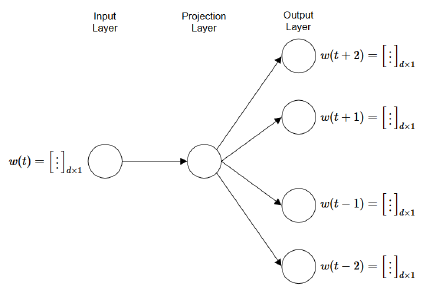

Como já definimos o vocabulário anteriormente, vamos criar os exemplos para treinamento da arquitetura. Veja que agora daremos o token alvo como entrada e orientaremos a arquitetura neural a prever as palavras ao redor: 

In [ ]:
def context_window(tokens, size=3):
  tokens = (['<pad>'] * size) + tokens + (['<pad>'] * size)

  contexts = []
  for i in range(size, len(tokens)-size):
    context = tokens[i-size:i] + tokens[i+1:i+size+1]
    word = tokens[i]
    contexts.extend([{ 'word': word, 'context': ctoken } for ctoken in context])
  return contexts

data = []
wsize = 10 # windows size
for review in treino:
  data.extend(context_window(review, size=wsize))

Veja que o modelo skip-gram é muito mais eficiente que o CBOW ao receber somente um token de entrada:

In [ ]:
data[8:12]

[{'context': '<pad>', 'word': 'a'},
 {'context': '<pad>', 'word': 'a'},
 {'context': 'americanas', 'word': 'a'},
 {'context': 'sempre', 'word': 'a'}]

Vamos definir o modelo skip-gram

In [ ]:
import torch
import torch.nn as nn
from torch import optim

class SkipGram(nn.Module):
  def __init__(self, inp_dim, nvocab, w2id, device):
    '''
    Inializando a arquitetura skip-gram

    params:
    ---
      inp_dim: dimensão dos word embeddings
      nvocab: tamanho do vocabulário de palavras
      w2id: mapping de um token para seu índice da matriz de embeddings
      device: hardware onde o modelo será alocado (e.g. cpu ou cuda)
    '''
    super(SkipGram, self).__init__()
    self.device = device
    self.w2id = w2id
    self.lookup = nn.Embedding(nvocab, inp_dim)
    self.Wb = nn.Linear(inp_dim, nvocab)
    self.softmax = nn.LogSoftmax(1)

  def forward(self, X):
    '''
    Forward pass

    params:
    ---
      X: tokens-alvo de entrada
    '''
    words = []
    for token in X:
      try:
        words.append(w2id[token])
      except:
        words.append(w2id['<oov>'])

    words = torch.tensor(words).to(self.device)
    embeddings = self.lookup(words)

    z = self.Wb(embeddings)
    return self.softmax(z)

Parâmetros do modelo neural e do treinamento

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inp_dim = 300
nvocab = len(vocab)
nepochs = 1
batch_size = 256
batch_status = 512
learning_rate = 0.01
window_size = wsize

Inicializando o modelo, a função de erro e o otimizador

In [ ]:
model = SkipGram(inp_dim, nvocab, w2id=w2id, device=device).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)

Separando os dados de treino em batches

In [ ]:
from torch.utils.data import DataLoader

traindata = DataLoader(data, batch_size=batch_size, shuffle=True)

Treinando o modelo

In [ ]:
for epoch in range(nepochs):
  losses = []
  for batch_idx, row in enumerate(traindata):
    X = row['word']
    y = []
    for context in row['context']:
      try:
        y.append(w2id[context])
      except:
        y.append(w2id['oov'])
    y = torch.tensor(y).to(device)

    # Forward
    outputs = model(X)
    
    # Calculate loss
    loss = criterion(outputs, y)
    losses.append(float(loss))
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(
                            epoch+1, batch_idx + 1, len(traindata),
                            100. * batch_idx / len(traindata), float(loss), 
                            round(sum(losses) / len(losses), 5)))

Train Epoch: 1 [512/16638 (3%)]	Loss: 7.039985	Total Loss: 6.941970
Train Epoch: 1 [1024/16638 (6%)]	Loss: 6.519051	Total Loss: 6.801060
Train Epoch: 1 [1536/16638 (9%)]	Loss: 6.155702	Total Loss: 6.704260
Train Epoch: 1 [2048/16638 (12%)]	Loss: 6.461795	Total Loss: 6.629280
Train Epoch: 1 [2560/16638 (15%)]	Loss: 6.893430	Total Loss: 6.573340
Train Epoch: 1 [3072/16638 (18%)]	Loss: 6.474667	Total Loss: 6.526900
Train Epoch: 1 [3584/16638 (22%)]	Loss: 5.792235	Total Loss: 6.483140
Train Epoch: 1 [4096/16638 (25%)]	Loss: 6.305014	Total Loss: 6.445060
Train Epoch: 1 [4608/16638 (28%)]	Loss: 6.069746	Total Loss: 6.413290
Train Epoch: 1 [5120/16638 (31%)]	Loss: 5.697777	Total Loss: 6.384130
Train Epoch: 1 [5632/16638 (34%)]	Loss: 6.318636	Total Loss: 6.360670
Train Epoch: 1 [6144/16638 (37%)]	Loss: 5.772650	Total Loss: 6.336350
Train Epoch: 1 [6656/16638 (40%)]	Loss: 6.025586	Total Loss: 6.313020
Train Epoch: 1 [7168/16638 (43%)]	Loss: 6.054763	Total Loss: 6.293220
Train Epoch: 1 [7680/166

Utilizando os word embeddings treinados

In [ ]:
embeddings = model.lookup.weight.data.cpu().numpy()

w2emb = { w:emb for (w, emb) in zip(vocab, list(embeddings))}

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity([w2emb['tv']], embeddings)[0]

candidates = sorted([(vocab[i], sim) for i, sim in enumerate(similarities)], key=lambda x: x[1], reverse=True)[:10]
for cand in candidates:
  print(cand)

('tv', 1.0000001)
('série', 0.29349968)
('smart', 0.27618968)
('ângulo', 0.26349553)
('d', 0.24426976)
('aplicativos', 0.22760302)
('esticada', 0.22515312)
('amarelo', 0.22332656)
('negativas', 0.22038236)
('bordas', 0.22017732)


# Modelos de Linguagem Neurais Pré-treinados

Modelos Neurais estado-da-arte são baseados na arquitetura Transformer e têm todos seus parâmetros pré-treinados com base em tarefas genéricas. Sendo assim, estes modelo só precisam ser refinados (*fine-tuned*) numa tarefa específica.

Vamos ver algumas aplicações de modelos pré-treinados utilizando a bibliotega [HuggingFace](https://huggingface.co/)


Vamos começar baixando as dependências

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 2.5MB 7.3MB/s 
     |████████████████████████████████| 3.3MB 36.0MB/s 
     |████████████████████████████████| 901kB 47.4MB/s 


## Classificação de Texto

Vamos refinar a arquitetura BERTimbau, versão em Português do BERT, numa tarefa de classificação onde uma revisão de produto será classificada em **Positiva**, **Neutra** ou **Negativa**.

In [ ]:
!wget https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv

--2021-07-06 03:30:14--  https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50591578 (48M) [text/plain]
Saving to: ‘B2W-Reviews01.csv’

B2W-Reviews01.csv   100%[===================>]  48.25M   107MB/s    in 0.4s    

2021-07-06 03:30:16 (107 MB/s) - ‘B2W-Reviews01.csv’ saved [50591578/50591578]



In [ ]:
!pip3 install transformers

     |████████████████████████████████| 2.5MB 9.0MB/s 
     |████████████████████████████████| 3.3MB 24.3MB/s 
     |████████████████████████████████| 901kB 39.6MB/s 


Preparando o córpus. 

**Observação:** Por motivos de demonstração, só utilizaremos 10 mil instâncias. Fique à vontade para utilizar mais exemplos no treinamento.

In [ ]:
import csv
from random import shuffle
import nltk
nltk.download('punkt')

with open('B2W-Reviews01.csv') as f:
  reader = csv.reader(f, delimiter=';', quotechar='\"')
  corpus = list(reader)

  header, corpus = corpus[0], corpus[1:]

corpus = corpus[:10000]
shuffle(corpus)

reviews = [w[10] for w in corpus]
ratings = [2 if w[8] in ['4', '5'] else 0 if w[8] in ['1', '2'] else 1 for w in corpus]
data = [{ 'X': review, 'y': rating } for (review, rating) in zip(reviews, ratings)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Separando os dados em conjunto de treino e teste

In [ ]:
size = int(len(data) * 0.2)
treino = data[size:]
teste = data[:size]

len(treino), len(teste)

(8000, 2000)

Importando as dependências. Perceba que o tokenizador e modelo de classificação do BERTimbau são instanciados com os métodos `AutoTokenizer` e `AutoModelForSequenceClassification`. 

Para mais informações, consulte [este link](https://github.com/neuralmind-ai/portuguese-bert).

In [ ]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

Instanciando parânetros da rede neural

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 3
nepochs = 5
batch_size = 8
batch_status = 32
learning_rate = 1e-5
early_stop = 2

max_length = 180
write_path = 'model'

Separando os dados em batches

In [ ]:
from torch.utils.data import DataLoader

traindata = DataLoader(treino, batch_size=batch_size, shuffle=True)
testdata = DataLoader(teste, batch_size=batch_size, shuffle=True)

Inicilizando tokenizador, modelo, função de erro e otimizador:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Definindo método de avaliação

In [ ]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['X'], inp['y']
    
    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)
                
    pred_labels = torch.argmax(output.logits, 1)
    
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negative', 'Neural', 'Positive']))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [ ]:
max_f1, repeat = 0, 0
for epoch in range(nepochs):
  model.train()
  f1, acc = evaluate(model, testdata)
  losses = []
  for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculate loss
    loss = output.loss
    losses.append(float(loss))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
        float(loss), round(sum(losses) / len(losses), 5)))
  
  f1, acc = evaluate(model, testdata)
  print('F1: ', f1, 'Accuracy: ', acc)
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  if repeat == early_stop:
    break

## Classificação de Tokens (muito-para-muitos)

Vamos agora refinar o modelo BERTimbau para uma tarefa de classificação de tokens.

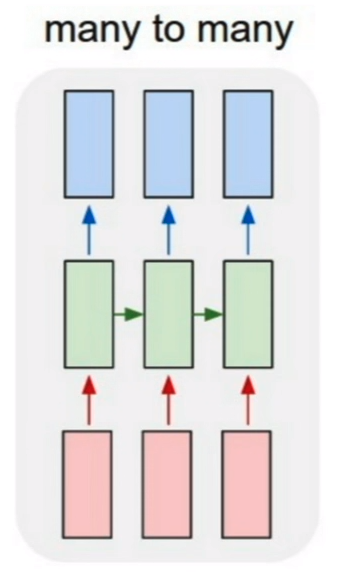

No caso, vamos treinar um *part-of-speech tagger*, i.e. um modelo que ache as classes gramaticais dos tokens de um texto.

Vamos utilizar o córpus [MacMorpho](http://nilc.icmc.usp.br/macmorpho/)

In [ ]:
!wget http://nilc.icmc.usp.br/macmorpho/macmorpho-v3.tgz
!tar -xvf macmorpho-v3.tgz

--2021-07-06 03:49:21--  http://nilc.icmc.usp.br/macmorpho/macmorpho-v3.tgz
Resolving nilc.icmc.usp.br (nilc.icmc.usp.br)... 143.107.183.225
Connecting to nilc.icmc.usp.br (nilc.icmc.usp.br)|143.107.183.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2463485 (2.3M) [application/x-gzip]
Saving to: ‘macmorpho-v3.tgz’

macmorpho-v3.tgz    100%[===================>]   2.35M   239KB/s    in 16s     

2021-07-06 03:49:37 (155 KB/s) - ‘macmorpho-v3.tgz’ saved [2463485/2463485]

macmorpho-dev.txt
macmorpho-test.txt
macmorpho-train.txt


Lendo o córpus

In [ ]:
with open('macmorpho-train.txt') as f:
  traindata = [[tuple(w.split('_'))for w in snt.split()] for snt in f.read().split('\n')]

with open('macmorpho-dev.txt') as f:
  devdata = [[tuple(w.split('_'))for w in snt.split()] for snt in f.read().split('\n')]

In [ ]:
def parse(data):
  X = [' '.join([w[0] for w in snt]) for snt in data]
  y = [[w[1] for w in snt] for snt in data]

  tags = []
  for snt in y:
    tags.extend(snt)
  tags = list(set(tags))
  tags.append('<pad>')
  tag2id = { tag:i for i, tag in enumerate(tags) }
  id2tag = { i:tag for i, tag in enumerate(tags) }
  return X, y, tag2id, id2tag

train_X, train_y, tag2id, id2tag = parse(traindata)
dev_X, dev_y, _, _ = parse(devdata)

In [ ]:
print(dev_X[0])
print(dev_y[0])

Ainda em dezembro de 1990 , foi editada a famosa 289 , que modificava a sistemática da arrecadação do ITR e alterava suas alíquotas .
['ADV', 'PREP', 'N', 'PREP', 'N', 'PU', 'V', 'PCP', 'ART', 'ADJ', 'N', 'PU', 'PRO-KS', 'V', 'ART', 'N', 'PREP+ART', 'N', 'PREP+ART', 'NPROP', 'KC', 'V', 'PROADJ', 'N', 'PU']


Como o tokenizador do BERTimbau pode segmentar o texto em sub-tokens, precisamos alinhá-los as tags que marcam as classes gramaticais

In [ ]:
# align
from transformers import AutoTokenizer

def align(X, y):
  tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
  
  procdata = []
  for (X_, y_) in zip(X, y):
    inputs = tokenizer(X_, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    try:
      new_tags = ['<pad>']
      pos = 0
      for token in tokens[1:-1]:
        if '##' in token:
          new_tags.append(y_[pos-1])
        else:
          new_tags.append(y_[pos])
          pos += 1
      new_tags.append('<pad>')

      procdata.append({ 'X': X_, 'y': ' '.join(new_tags) })
    except:
      pass
  return procdata

trainset = align(train_X, train_y)
devset = align(dev_X, dev_y)

len(trainset), len(devset)

(29418, 1573)

Importando dependências. Veja que utilizaremos os métodos `AutoTokenizer` e `AutoModelForTokenClassification` para instanciar o tokenizador e o modelo de classificação de tokens.

In [ ]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

Definindo parâmetros do modelo e treinamento

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = len(tag2id)
nepochs = 1
batch_size = 16
batch_status = 32
learning_rate = 1e-5

early_stop = 2
max_length = 180
write_path = 'model'

Separando os dados em batches

In [ ]:
from torch.utils.data import DataLoader

traindata = DataLoader(trainset, batch_size=batch_size, shuffle=True)
devdata = DataLoader(devset, batch_size=batch_size, shuffle=True)

Inicializando tokenizador, modelo, função de erro e otimizador

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
model = AutoModelForTokenClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Método de Avaliação

In [ ]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts = inp['X']

    labels = []
    for tags in inp['y']:
      tag_idxs = [tag2id[tag] for tag in tags.split()]
      labels.append(tag_idxs)
    
    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)
                
    pred_labels = torch.argmax(output.logits, 2).tolist()

    for i in range(len(labels)):
      y_real.extend(labels[i][1:-1])
      seq_size = len(labels[i][1:-1])
      y_pred.extend(pred_labels[i][1:seq_size+1])
    
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [ ]:
from torch.nn.utils.rnn import pad_sequence

max_f1, repeat = 0, 0
for epoch in range(nepochs):
  model.train()
  losses = []
  for batch_idx, inp in enumerate(traindata):
    texts = inp['X']
    
    labels = []
    for tags in inp['y']:
      tag_idxs = [tag2id[tag] for tag in tags.split()]
      labels.append(torch.tensor(tag_idxs[:max_length]))
    
    labels= pad_sequence(labels, padding_value=tag2id['<pad>']).transpose(0, 1).unsqueeze(0).contiguous()

    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculate loss
    loss = output.loss
    losses.append(float(loss))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
        float(loss), round(sum(losses) / len(losses), 5)))
  
  f1, acc = evaluate(model, devdata)
  print('F1: ', f1, 'Accuracy: ', acc)
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  if repeat == early_stop:
    break

Train Epoch: 0 [32/1839 (2%)]	Loss: 2.509035	Total Loss: 2.949510
Train Epoch: 0 [64/1839 (3%)]	Loss: 1.652718	Total Loss: 2.531190
Train Epoch: 0 [96/1839 (5%)]	Loss: 1.028637	Total Loss: 2.126400
Train Epoch: 0 [128/1839 (7%)]	Loss: 0.558758	Total Loss: 1.781310
Train Epoch: 0 [160/1839 (9%)]	Loss: 0.296658	Total Loss: 1.518370
Train Epoch: 0 [192/1839 (10%)]	Loss: 0.242666	Total Loss: 1.324220
Train Epoch: 0 [224/1839 (12%)]	Loss: 0.280598	Total Loss: 1.175120
Train Epoch: 0 [256/1839 (14%)]	Loss: 0.283331	Total Loss: 1.057900
Train Epoch: 0 [288/1839 (16%)]	Loss: 0.215786	Total Loss: 0.963120
Train Epoch: 0 [320/1839 (17%)]	Loss: 0.224189	Total Loss: 0.886100
Train Epoch: 0 [352/1839 (19%)]	Loss: 0.130807	Total Loss: 0.821390
Train Epoch: 0 [384/1839 (21%)]	Loss: 0.142504	Total Loss: 0.767040
Train Epoch: 0 [416/1839 (23%)]	Loss: 0.193308	Total Loss: 0.719990
Train Epoch: 0 [448/1839 (24%)]	Loss: 0.179299	Total Loss: 0.678860
Train Epoch: 0 [480/1839 (26%)]	Loss: 0.077677	Total Los

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:  0.9800131229931577 Accuracy:  0.9803136766580687
Saving best model...


## Geração

Vamos utilizar um modelo de linguagem neural para treinar uma máquina de tradução Inglês-Português.

In [ ]:
!pip3 install sentencepiece
!pip3 install transformers
!pip3 install translate-toolkit

Vamos utilizar um córpus de legendas de TED talks

In [ ]:
!wget https://object.pouta.csc.fi/OPUS-TED2020/v1/tmx/en-pt_br.tmx.gz
!gunzip en-pt_br.tmx.gz

--2021-07-06 04:22:48--  https://object.pouta.csc.fi/OPUS-TED2020/v1/tmx/en-pt_br.tmx.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32862474 (31M) [application/gzip]
Saving to: ‘en-pt_br.tmx.gz’

en-pt_br.tmx.gz     100%[===================>]  31.34M  9.91MB/s    in 3.2s    

2021-07-06 04:22:53 (9.91 MB/s) - ‘en-pt_br.tmx.gz’ saved [32862474/32862474]

gzip: en-pt_br.tmx already exists; do you wish to overwrite (y or n)? ^C


Lendo o córpus e separando em conjuntos de treino e teste

In [ ]:
from translate.storage.tmx import tmxfile
from random import shuffle

# ler córpus
with open("en-pt_br.tmx", 'rb') as fin:
  f = tmxfile(fin, 'en', 'pt')

prefixo = '>>pt_br<<'
# formatar as traduções corretamente 
data = [{ 'src': prefixo + ' ' + w.source, 'trg': w.target } for w in f.unit_iter()]
# embaralhar os pares
shuffle(data)
# separar em conjuntos de treino e teste
size = int(len(data) * 0.2)
treino = data[size:][:10000]
teste = data[:size][:1000]

In [ ]:
treino[10]

{'src': ">>pt_br<< Actually, technically, it's not a rectum. It's called a cloaca. ",
 'trg': 'Na verdade, tecnicamente, não é um reto. '}

Definindo parâmetros do modelo e treinamento

In [ ]:
learning_rate = 1e-5 # taxa de aprendizado
epocas = 2 # número de épocas
batch_size = 16 # tamanho do batch
batch_status = 32
early_stop = 5
write_path='model.pt' # caminho para salvar o melhor modelo

Separando dados em batches

In [ ]:
from torch.utils.data import DataLoader

traindata = DataLoader(treino, batch_size=batch_size, shuffle=True)
devdata = DataLoader(teste, batch_size=batch_size, shuffle=True)

Método de Avaliação

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate(tokenizer, model, devdata, batch_size, batch_status, device):
    model.eval()
    y_real = []
    y_pred = []
    for batch_idx, inp in enumerate(devdata):
        y_real.extend(inp['trg'])
        # tokenize
        model_inputs = tokenizer(inp['src'], truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        # Translate
        generated_ids = model.generate(**model_inputs, num_beams=1)
        # Post-process translation
        output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        y_pred.extend(output)
    
        # Display
        if (batch_idx+1) % batch_status == 0:
            print('Evaluation: [{}/{} ({:.0f}%)]'.format(batch_idx+1, \
                len(devdata), 100. * batch_idx / len(devdata)))

    # evaluating based on bleu
    hyps, refs = [], []
    for i, snt_pred in enumerate(y_pred):
        hyps.append(nltk.word_tokenize(snt_pred))
        refs.append([nltk.word_tokenize(y_real[i])])
    bleu = corpus_bleu(refs, hyps)

    return bleu

Método de Treinamento

In [ ]:
def train(tokenizer, model, traindata, devdata, optimizer, num_epochs, batch_size, batch_status, device, early_stop=5, write_path='model.pt'):
  max_bleu = evaluate(tokenizer, model, devdata, batch_size, batch_status, device)
  print('BLEU inicial:', max_bleu)
  model.train()
  repeat = 0
  for epoch in range(num_epochs):
    losses = []
    batch_src, batch_trg = [], []

    for batch_idx, inp in enumerate(traindata):
        # Init
        optimizer.zero_grad()

        # tokenize
        model_inputs = tokenizer(inp['src'], truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        with tokenizer.as_target_tokenizer():
          labels = tokenizer(inp['trg'], truncation=True, padding=True, max_length=128, return_tensors="pt").input_ids.to(device)
        # translate
        output = model(**model_inputs, labels=labels) # forward pass

        # Calculate loss
        loss = output.loss
        losses.append(float(loss))

        # Backpropagation
        loss.backward()
        optimizer.step()

        batch_src, batch_trg = [], []

        # Display
        if (batch_idx+1) % batch_status == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(
            epoch, batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), float(loss), round(sum(losses) / len(losses), 5)))
    
    bleu = evaluate(tokenizer, model, devdata, batch_size, batch_status, device)
    print('BLEU:', bleu)
    if bleu > max_bleu:
        max_bleu = bleu
        repeat = 0

        print('Saving best model...')
        torch.save(model, write_path)
    else:
        repeat += 1

    if repeat == early_stop:
        break

Inicializando o Modelo

In [ ]:
import nltk
nltk.download('punkt')
import torch
from torch import optim
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ROMANCE").to(device)
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ROMANCE")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Treinando

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
train(tokenizer, model, traindata, devdata, optimizer, epocas, batch_size, batch_status, device, early_stop, write_path)

Evaluation: [32/63 (49%)]
BLEU inicial: 0.3911056291316303
Train Epoch: 0 [32/625 (5%)]	Loss: 0.533786	Total Loss: 0.834320
Train Epoch: 0 [64/625 (10%)]	Loss: 0.631620	Total Loss: 0.703680
Train Epoch: 0 [96/625 (15%)]	Loss: 0.397847	Total Loss: 0.628520
Train Epoch: 0 [128/625 (20%)]	Loss: 0.591209	Total Loss: 0.596150
Train Epoch: 0 [160/625 (25%)]	Loss: 0.528577	Total Loss: 0.576380
Train Epoch: 0 [192/625 (31%)]	Loss: 0.675588	Total Loss: 0.557740
Train Epoch: 0 [224/625 (36%)]	Loss: 0.597750	Total Loss: 0.544460
Train Epoch: 0 [256/625 (41%)]	Loss: 0.537057	Total Loss: 0.535850
Train Epoch: 0 [288/625 (46%)]	Loss: 0.627591	Total Loss: 0.528780
Train Epoch: 0 [320/625 (51%)]	Loss: 0.585321	Total Loss: 0.525520
Train Epoch: 0 [352/625 (56%)]	Loss: 0.446157	Total Loss: 0.521160
Train Epoch: 0 [384/625 (61%)]	Loss: 0.446790	Total Loss: 0.514810
Train Epoch: 0 [416/625 (66%)]	Loss: 0.570976	Total Loss: 0.513190
Train Epoch: 0 [448/625 (72%)]	Loss: 0.463745	Total Loss: 0.510530
Train E

In [ ]:
# sentenças a serem traduzidas
batch_input_str = ((">>pt_br<< We can do better, America can do better, and help is on the way."), 
                   (">>pt_br<< Equal access to public education has been gained."), 
                   (">>pt_br<< We thought that these elections would bring the Iraqis together, and that as we trained Iraqi security forces we could accomplish our mission with fewer American troops."))
# tokenizando as sentenças
encoded = tokenizer(batch_input_str, return_tensors='pt', padding=True).to(device)
# traduzindo
translated = model.generate(**encoded)
# preparando a saída
tokenizer.batch_decode(translated, skip_special_tokens=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


['Podemos fazer melhor, os EUA podem fazer melhor, e a ajuda está a caminho.',
 'A igualdade de acesso à educação pública foi conseguida.',
 'Pensamos que essas eleições uniriam os iraquianos, e que, ao treinarmos as forças de segurança iraquianas, poderíamos realizar nossa missão com menos tropas americanas.']